In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB5
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
import warnings warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub, os

path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Downloaded dataset path:", path)
print("Contents:", os.listdir(path))

dataset_path = os.path.join(path, "color")
print("Dataset path set to:", dataset_path)

Downloaded dataset path: /kaggle/input/plantvillage-dataset
Contents: ['plantvillage dataset']
Dataset path set to: /kaggle/input/plantvillage-dataset/color


In [ ]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in tqdm(os.listdir(dataset_path)):
        subfolder_path = os.path.join(dataset_path, subfolder)
        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [ ]:
dataset_path = os.path.join(path, "plantvillage dataset", "color")
print("Dataset path set to:", dataset_path)

train = data(dataset_path)
train.head()

Dataset path set to: /kaggle/input/plantvillage-dataset/plantvillage dataset/color


100%|██████████| 38/38 [00:02<00:00, 15.07it/s]


,image,label
0,/kaggle/input/plantvillage-dataset/plantvillag...,Tomato___Late_blight
1,/kaggle/input/plantvillage-dataset/plantvillag...,Tomato___Late_blight
2,/kaggle/input/plantvillage-dataset/plantvillag...,Tomato___Late_blight
3,/kaggle/input/plantvillage-dataset/plantvillag...,Tomato___Late_blight
4,/kaggle/input/plantvillage-dataset/plantvillag...,Tomato___Late_blight


In [ ]:
train.shape

(54305, 2)

In [ ]:
train.label.value_counts().to_frame()

,count
label,
Orange___Haunglongbing_(Citrus_greening),5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus,5357
Soybean___healthy,5090
Peach___Bacterial_spot,2297
Tomato___Bacterial_spot,2127
Tomato___Late_blight,1909
Squash___Powdery_mildew,1835
Tomato___Septoria_leaf_spot,1771
Tomato___Spider_mites Two-spotted_spider_mite,1676


In [ ]:
X_train, X_test1, y_train, y_test1 = train_test_split(train['image'], train['label'], test_size=0.2, random_state=42,shuffle=True,stratify=train['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
# 'df_train', 'df_val', 'df_test' are defined and contain image paths and labels
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [ ]:
image_size = (150, 150)  # Target size for the images
batch_size = 32  # Batch size

# Define ImageDataGenerators for training, validation, and testing
datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0, 1]
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train generator: Assuming df_train contains a column 'image' with image file paths and 'label' with class labels
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,  # Set directory to None if absolute paths are already in 'image' column
    x_col='image',   # Column with image paths
    y_col='label',   # Column with labels
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'  # Assuming multi-class classification (one-hot encoding)
)

# Test generator
test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=None,  # Use None if the paths in 'image' column are already absolute
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

# Validation generator
val_generator = datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=None,  # Use None if the paths are absolute
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)


Found 43444 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.


In [ ]:
class_ = test_generator.class_indices.keys()
class_ = list(class_)

# **MobileNetV2**

In [ ]:
# Load Pre-trained MobileNetV2
mobilenet_base = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3),
    pooling='max'
)

# Custom Layers
mobilenet_head = mobilenet_base.output
mobilenet_head = layers.Dense(512, activation='relu')(mobilenet_head)
mobilenet_head = layers.Dropout(0.5)(mobilenet_head)
mobilenet_output = layers.Dense(38, activation='softmax')(mobilenet_head)  # 38 classes

# Build Model
mobilenet_model = models.Model(inputs=mobilenet_base.input, outputs=mobilenet_output)

# Compile Model
mobilenet_optimizer = Adam(learning_rate=0.0001)
mobilenet_model.compile(
    optimizer=mobilenet_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
mobilenet_checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/Best-Models/mobilenetv2_best.keras", save_best_only=True)
mobilenet_early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Train Model
mobilenet_history = mobilenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[mobilenet_checkpoint_cb, mobilenet_early_stopping_cb]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 722s 488ms/step - accuracy: 0.5467 - loss: 2.2391 - val_accuracy: 0.7320 - val_loss: 0.9975
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 349s 256ms/step - accuracy: 0.8996 - loss: 0.3232 - val_accuracy: 0.9254 - val_loss: 0.2397
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 345s 254ms/step - accuracy: 0.9413 - loss: 0.1896 - val_accuracy: 0.9608 - val_loss: 0.1117
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 347s 256ms/step - accuracy: 0.9548 - loss: 0.1458 - val_accuracy: 0.9779 - val_loss: 0.0642
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 351s 258ms/step - accuracy: 0.9654 - loss: 0.1166 - val_accuracy: 0.9750 - val_loss: 0.0800
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 347s 256ms/step - accuracy: 0.9687 - loss: 0.0989 - val_accuracy: 0.9652 - val_loss: 0.1162
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 349s 257ms/step - accuracy: 0.9731 - loss: 0.0870 - val_accuracy: 0.9702 - val_loss: 0.1383
Epoch 8/10
13

In [ ]:
# History of training accuracy-loss vs validation accuracy-loss
hist_=pd.DataFrame(mobilenet_history.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.724358,1.108402,0.732044,0.997537
1,0.913291,0.281738,0.925414,0.239750
2,0.944987,0.180168,0.960773,0.111724
3,0.955690,0.142903,0.977901,0.064169
4,0.965565,0.115558,0.974954,0.079988
5,0.970353,0.094230,0.965193,0.116206
6,0.972885,0.088817,0.970166,0.138345
7,0.976475,0.076484,0.960958,0.147905
8,0.980319,0.068648,0.987845,0.039416
9,0.980780,0.061994,0.978085,0.067384


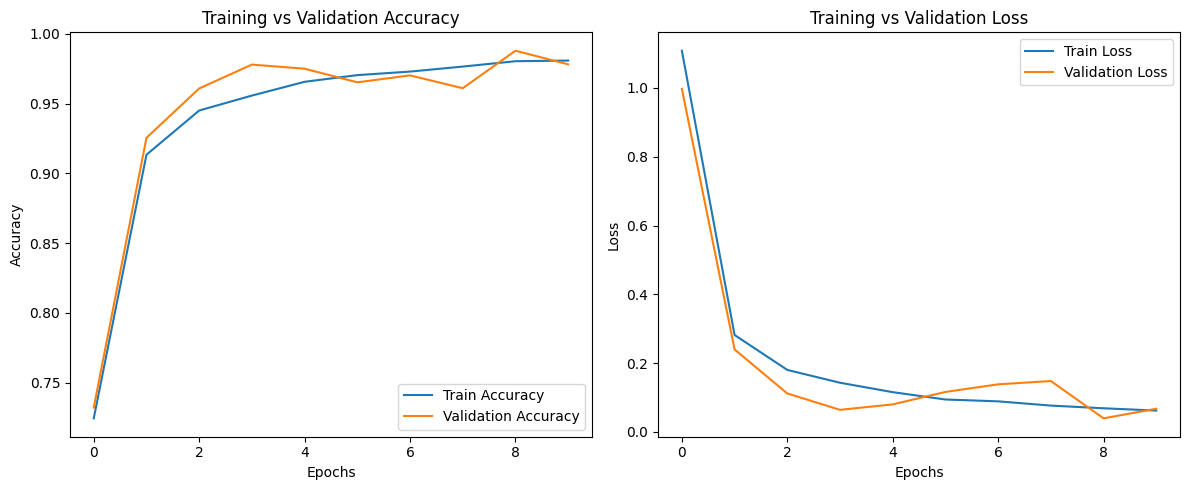

In [ ]:
# Plot Training vs Validation Accuracy
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(mobilenet_history.history['accuracy'], label='Train Accuracy')
plt.plot(mobilenet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(mobilenet_history.history['loss'], label='Train Loss')
plt.plot(mobilenet_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test data
loss, accuracy = mobilenet_model.evaluate(test_generator)

# Print the test accuracy and loss
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

170/170 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9858 - loss: 0.0459
Test Accuracy: 0.9875
Test Loss: 0.0430


In [ ]:
# True labels from test_generator
y_true = test_generator.classes

# Predict probabilities for each class
y_probs = mobilenet_model.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_probs, axis=1)

# Flatten arrays
y_true = np.ravel(y_true)
y_pred = np.ravel(y_pred)

# Create a DataFrame to compare actual vs predicted labels
df_compare = pd.DataFrame({
    'Actual': y_true,
    'Prediction': y_pred
})

# Display first few rows
df_compare.head()

170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step


,Actual,Prediction
0,1,1
1,17,17
2,24,24
3,19,19
4,31,31


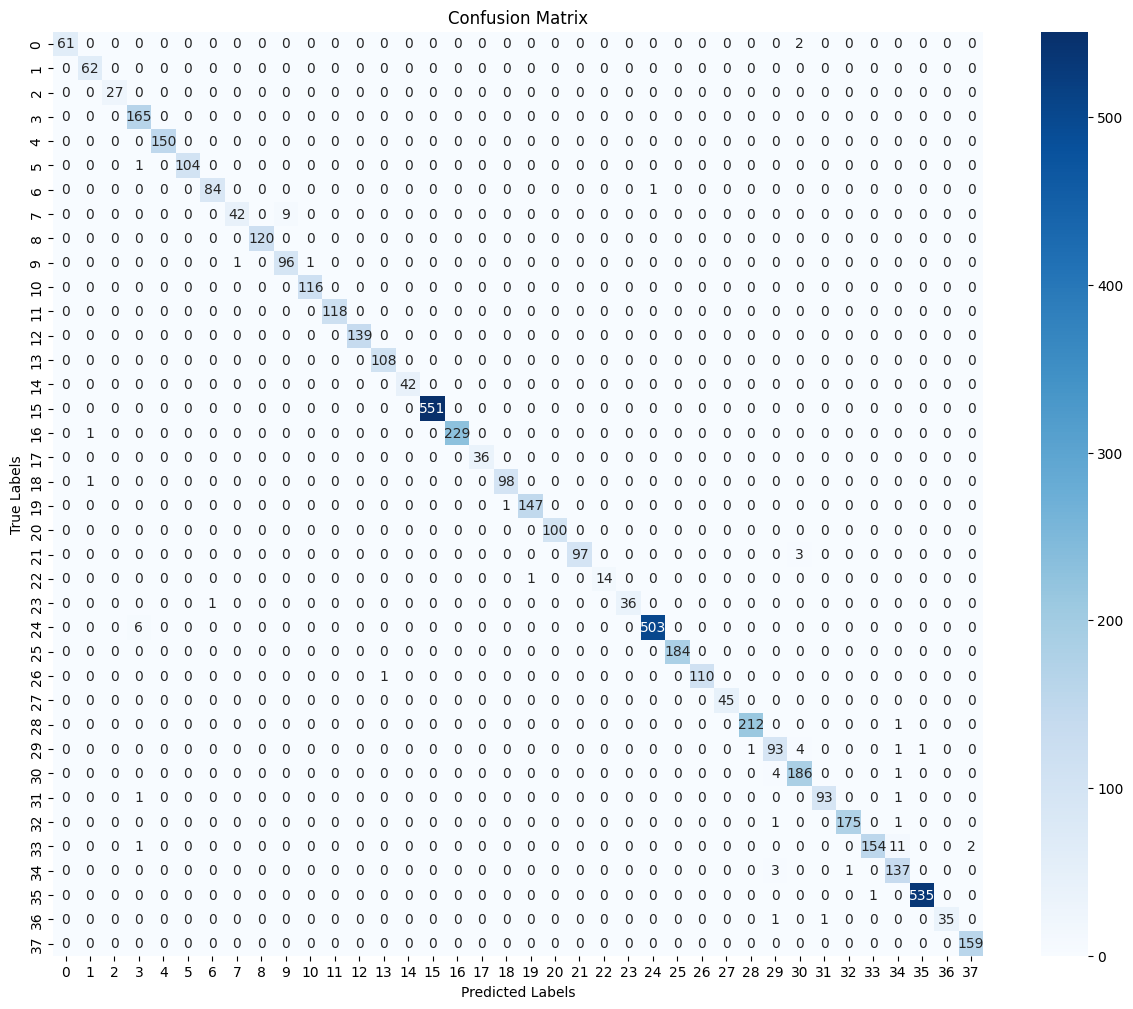

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
ClassificationReport = classification_report(y_true, y_pred, target_names=class_)
print('Classification Report is:\n', ClassificationReport)

Classification Report is:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.97      0.98        63
                                 Apple___Black_rot       0.97      1.00      0.98        62
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        27
                                   Apple___healthy       0.95      1.00      0.97       165
                               Blueberry___healthy       1.00      1.00      1.00       150
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      1.00       105
                 Cherry_(including_sour)___healthy       0.99      0.99      0.99        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.82      0.89        51
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       120
               Corn_(maize)___Northern_Leaf_Blight  

# **CNN**

In [ ]:
# Build CNN Model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(38, activation='softmax')  # 38 classes
])

# Compile Model
cnn_optimizer = Adam(learning_rate=0.001)
cnn_model.compile(
    optimizer=cnn_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,053,158 (72.68 MB)

 Trainable params: 19,053,158 (72.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
cnn_checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/Best-Models/cnn_best.keras", save_best_only=True)
cnn_early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Train Model
cnn_history = cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[cnn_checkpoint_cb, cnn_early_stopping_cb]
)

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 351s 254ms/step - accuracy: 0.4650 - loss: 1.9581 - val_accuracy: 0.7926 - val_loss: 0.6914
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 325s 239ms/step - accuracy: 0.7880 - loss: 0.6723 - val_accuracy: 0.8164 - val_loss: 0.5891
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 330s 243ms/step - accuracy: 0.8583 - loss: 0.4407 - val_accuracy: 0.8486 - val_loss: 0.5502
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 327s 241ms/step - accuracy: 0.8844 - loss: 0.3455 - val_accuracy: 0.8453 - val_loss: 0.5097
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 342s 252ms/step - accuracy: 0.9024 - loss: 0.2933 - val_accuracy: 0.8936 - val_loss: 0.3507
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 333s 245ms/step - accuracy: 0.9171 - loss: 0.2474 - val_accuracy: 0.9096 - val_loss: 0.3153
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 328s 242ms/step - accuracy: 0.9232 - loss: 0.2356 - val_accuracy: 0.9177 - val_loss: 0.2725
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 327s 240ms/step - ac

In [ ]:
# History of training accuracy-loss vs validation accuracy-loss
hist_cnn = pd.DataFrame(cnn_history.history)
display(hist_cnn)

,accuracy,loss,val_accuracy,val_loss
0,0.614377,1.328230,0.792634,0.691404
1,0.812563,0.586600,0.816390,0.589102
2,0.863779,0.421638,0.848619,0.550162
3,0.890411,0.334895,0.845304,0.509669
4,0.905557,0.285973,0.893554,0.350652
5,0.918677,0.244983,0.909576,0.315307
6,0.925076,0.228256,0.917680,0.272481
7,0.930278,0.214433,0.922836,0.252825
8,0.936999,0.190640,0.957090,0.129875
9,0.941189,0.177992,0.937017,0.197263


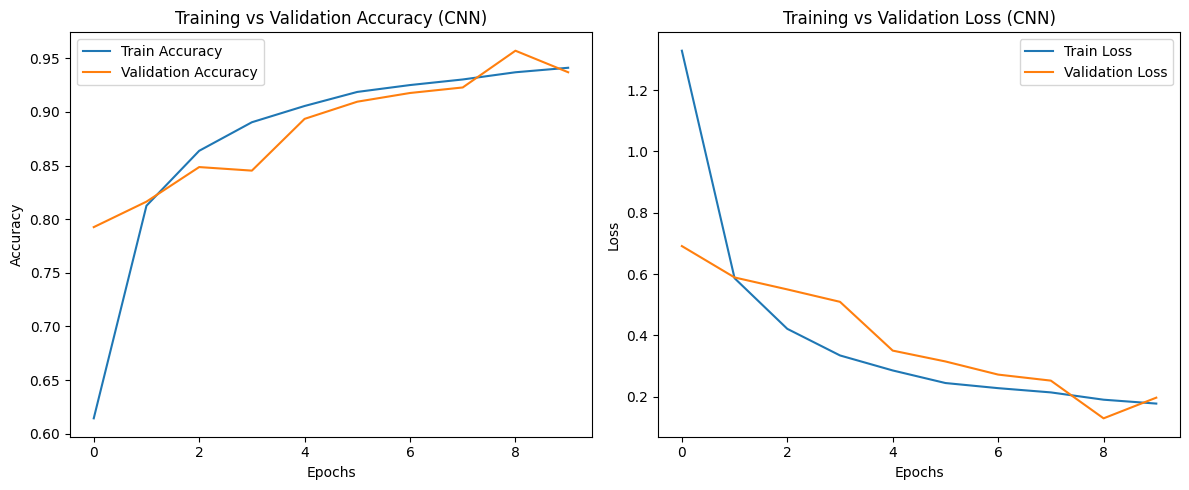

In [ ]:
# Plot Training vs Validation Accuracy
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test data
loss_cnn, accuracy_cnn = cnn_model.evaluate(test_generator)

# Print the test accuracy and loss
print(f"CNN Test Accuracy: {accuracy_cnn:.4f}")
print(f"CNN Test Loss: {loss_cnn:.4f}")

170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9541 - loss: 0.1462
CNN Test Accuracy: 0.9595
CNN Test Loss: 0.1339


In [ ]:
# Predict probabilities for each class
y_probs_cnn = cnn_model.predict(test_generator)

# Convert probabilities to class labels
y_pred_cnn = np.argmax(y_probs_cnn, axis=1)

#  Flatten arrays
y_pred_cnn = np.ravel(y_pred_cnn)

# Create a DataFrame to compare actual vs predicted labels
df_compare_cnn = pd.DataFrame({
    'Actual': y_true,
    'Prediction_CNN': y_pred_cnn
})

# Display first few rows
display(df_compare_cnn.head())

170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step


,Actual,Prediction_CNN
0,1,1
1,17,17
2,24,24
3,19,19
4,31,31


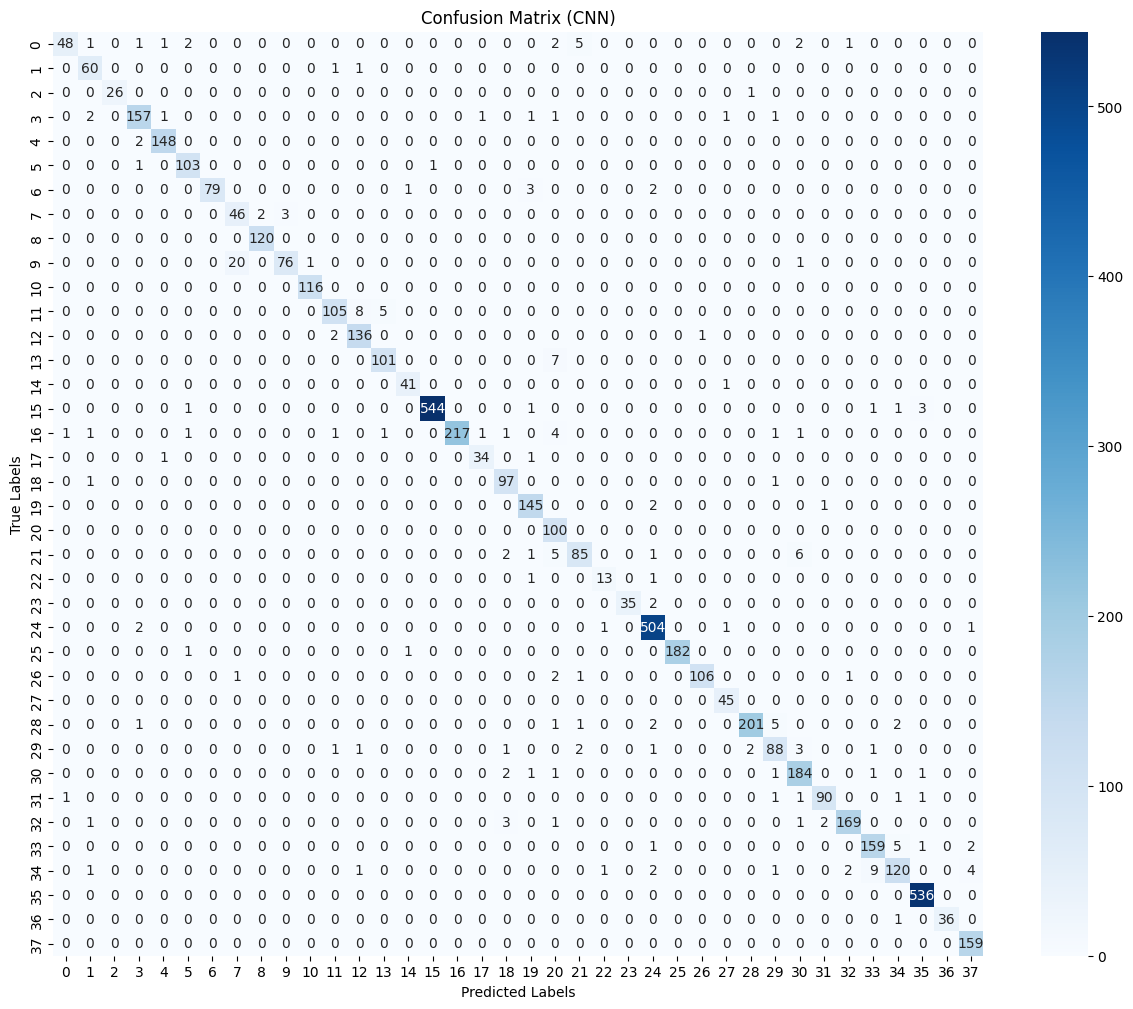

In [ ]:
# Confusion Matrix
cm_cnn = confusion_matrix(y_true, y_pred_cnn)

plt.figure(figsize=(15,12))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (CNN)')
plt.show()

In [ ]:
# Classification Report
ClassificationReport_cnn = classification_report(y_true, y_pred_cnn, target_names=class_)
print('Classification Report (CNN) is:\n', ClassificationReport_cnn)

Classification Report (CNN) is:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.76      0.85        63
                                 Apple___Black_rot       0.90      0.97      0.93        62
                          Apple___Cedar_apple_rust       1.00      0.96      0.98        27
                                   Apple___healthy       0.96      0.95      0.95       165
                               Blueberry___healthy       0.98      0.99      0.98       150
          Cherry_(including_sour)___Powdery_mildew       0.95      0.98      0.97       105
                 Cherry_(including_sour)___healthy       1.00      0.93      0.96        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.69      0.90      0.78        51
                       Corn_(maize)___Common_rust_       0.98      1.00      0.99       120
               Corn_(maize)___Northern_Leaf_Bl